In [23]:
%autosave 0

Autosave disabled


regression = mean of 1 dependent vs multi dependents


Predict target variable performance = baseline + computing metrics + comparing those metrics across multiple models

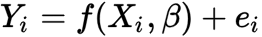

#### Goals : 
+"good enough" vs baseline to find LINE OF BEST FIT(regression line)
+compute various regression evaluation metrics using sklearn.metrics
+select best model using those evaluation metrics


#### Questions:
1.How do we know if our model is good enough?
    we know the model has Goodness of Fit Metrics if the R-squared (measure proportion of the variance in the dependent variable explained by the independent variables). R2 close to 1 is better fit. Adjusted R-squared penalizes models with many irrelevant features if the model has overfitting issues. high R-square and adjusted R-square value indicate that model is significant.
     we can also use residual analysis(actual value - predicted value). Should show irregular distribution and no systematic patterns on scatter plot
     The lower the Mean Absolute Error(MAE) and Root Mean Squared Error (RMSE) the better model fit.
           

2.How do we find the line of best fit?
    line of best fit determine by coefficient (slope and intercept) that minimize sum of squared residuals using Ordinary least Squares (OLS) or gradient descent

3.How do we evaluate our model?
    It should have a high R2, low MAE/RMSE, normally distributed residuals, meaningful features. Use Cross-Validation to assess how well the model geeneralize unseen data. High score in cross-validation is good predictive performance.
    we can compare it to mean or median baseline prediction.
    apply regularization techniques to prevent overfitting and improve model generalization.



4.Are our features valuable?
    not all features are valuable dependent on specific problem and goals. Use Feature Importance Scores or Coefficients in linear regression to determine which featuers contribute most. Use forward/backward selection or Lasso/Ridge regularization to id valuable resource and reduce overfitting
    


In [24]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from adam_wrangle import train_val_test
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from math import sqrt

Let's read in the diamonds csv from the explore lesson.

In [25]:
df = pd.read_csv('diamonds.csv', index_col=0)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


We have to split our data before we can fit a model to our data and generate some predictions.

In [26]:
train, val, test = train_val_test(df)
train.shape, val.shape, test.shape

((37758, 10), (8091, 10), (8091, 10))

Let's make X and y train series. Let's use carat, since we found it to have a strong positive correlation with our target variable (price) during the explore phase.

In [27]:
X_train = train[['carat']]
y_train = train.price

X_val = val[['carat']]
y_val = val.price

Let's define a baseline. We will go through the manual calculations using our baseline. At the end, we will create a basic linear regression model and evaluate it using the imported functions.

Since we have no way of knowing if the median or the mean performs better, we'll use the median.

In [28]:
y_train.median()

2404.0

Let's assign our baseline to a new column of y_train.

In [29]:
y_train.head()  #actual value

19498     8131
31230      756
22312    10351
279       2795
6647      4092
Name: price, dtype: int64

In [30]:
#let's create a data frame from this using dictionary method
#make sure it work before assign it to the dataframe preds
preds=pd.DataFrame({'y_actual': y_train,
             'y_baseline': y_train.median()})
preds.head()

,y_actual,y_baseline
19498,8131,2404.0
31230,756,2404.0
22312,10351,2404.0
279,2795,2404.0
6647,4092,2404.0


Let's calculate the residuals, which are the predicted values minus the actual ones.

In [31]:
preds['y_baseline_resids'] = preds['y_baseline'] - preds['y_actual']
preds.head()

,y_actual,y_baseline,y_baseline_resids
19498,8131,2404.0,-5727.0
31230,756,2404.0,1648.0
22312,10351,2404.0,-7947.0
279,2795,2404.0,-391.0
6647,4092,2404.0,-1688.0


Text(0.5, 1.0, 'guesses from the actual')

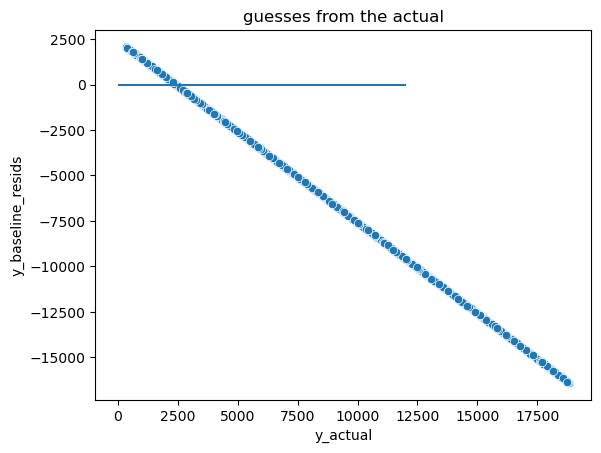

In [32]:
sns.scatterplot(data = preds, x = 'y_actual', y = 'y_baseline_resids')
plt.hlines(0,0,12000)
plt.title("guesses from the actual")

Now we can square the residuals, to eliminate the differences in the signs. This calculates the squared errors.

In [33]:
preds['y_baseline_resids_sq'] = preds['y_baseline_resids'] ** 2
preds.head()

,y_actual,y_baseline,y_baseline_resids,y_baseline_resids_sq
19498,8131,2404.0,-5727.0,32798529.0
31230,756,2404.0,1648.0,2715904.0
22312,10351,2404.0,-7947.0,63154809.0
279,2795,2404.0,-391.0,152881.0
6647,4092,2404.0,-1688.0,2849344.0


We can add all the squared errors together, to calculate the sum of squared errors (SSE). This is the first acronym you encountered in the curriculum.

In [34]:
sse_baseline = preds['y_baseline_resids_sq'].sum()
sse_baseline
#sum of all square error made by our baseline model , and it sucks

696475923920.0

The next step is to calculate the mean squared error (MSE). As the name implies, we calculate this value by getting the average of the squared error. We can divide the sum of squared errors (SSE) by the length of the dataframe to calculate this value.

In [35]:
mse_baseline = sse_baseline/ len(preds)
mse_baseline

#on avg this model made this much square error

18445784.308490917

Finally, as the name implies, we can calculate the root mean squared error (RMSE) by taking the square root of the mean squared error (MSE). This will return a value that represents the average error in our baseline's predictions in the original units.

In [36]:
rmse_baseline = sqrt(mse_baseline)
rmse_baseline

# 

4294.855563169839

Now that we've done it the long way with the baseline, let's create a basic linear regression model and evaluate it with the help of the sklearn library.

## DO this the short way

In [37]:
lm = LinearRegression()
lm.fit(X_train, y_train)
preds['y_hat'] = lm.predict(X_train)

In [38]:
rmse_model = sqrt(mean_squared_error(preds['y_actual'], preds['y_hat']))
rmse_model

1553.8093867380917

Great! We were able to calculate the root mean squared error (RMSE) for our baseline and regression model. Which one performed better?

In [39]:
print(f'RMSE of our baseline: {round(rmse_baseline)}')
print(f'RMSE of our finely tuned model: {round(rmse_model)}')

RMSE of our baseline: 4295
RMSE of our finely tuned model: 1554


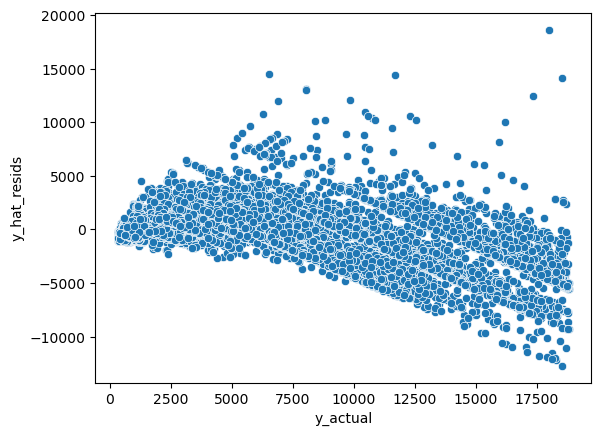

In [40]:
preds['y_hat_resids'] = preds['y_hat'] - preds['y_actual']
sns.scatterplot(data = preds, x='y_actual', y='y_hat_resids')
plt.show()

#see where your data struggle in any particular area

Now let's calculate the model significance. This can also be expressed as the R^2 value. The R^2 value equals the explained sum of squares divided by the total sum of squares. The equation with acronyms looks like this: R^2 = ESS / TSS.

The first step is to calculated the explained sum of squares. This is calculated by taking each prediction, subtracting the mean of actual values, squaring it, and adding up all the results. It's very similar to how we calculated the sum of squared errors (SSE).

In [41]:
#we have to dive back in alphalbet soup 
preds['y_baseline_minus_mean'] = preds['y_baseline'] - preds['y_actual'].mean()
preds.head()

,y_actual,y_baseline,y_baseline_resids,y_baseline_resids_sq,y_hat,y_hat_resids,y_baseline_minus_mean
19498,8131,2404.0,-5727.0,32798529.0,7137.116468,-993.883532,-1547.495312
31230,756,2404.0,1648.0,2715904.0,148.330012,-607.669988,-1547.495312
22312,10351,2404.0,-7947.0,63154809.0,7137.116468,-3213.883532,-1547.495312
279,2795,2404.0,-391.0,152881.0,4030.989154,1235.989154,-1547.495312
6647,4092,2404.0,-1688.0,2849344.0,3875.682788,-216.317212,-1547.495312


In [42]:
ess_baseline = sum(preds['y_baseline_minus_mean']**2)
ess_baseline

90420658673.29518

In [43]:
ess_baseline = sum(preds['y_baseline_minus_mean'] ** 2)
ess_baseline

90420658673.29518

Now that we have our explained sum of squares, we have the nominator for our equation. To calculate the denominator, the total sum of squares (TSS), we have to add the sum of squared error (SSE) to the explained sum of squares (ESS).

In [44]:
tss_baseline = sse_baseline + ess_baseline
tss_baseline

786896582593.2952

We have both elements ready! We divide the ESS by the TSS to find the model significance for our baseline.

In [45]:
r_baseline = ess_baseline / tss_baseline
r_baseline

0.11490793158016394

After doing it the long way, let's calculate model significance for our linear regression model using the sklearn library.

In [46]:
r2_score(preds['y_actual'], preds['y_hat'])

0.8495846235389342